## StackOverflow questions tagging with logistic regression

We will code a model for predicting tags based on a multilabel logistic regression. Unlike the usual setting of a multiclass problem, in this case one example can belong to several classes. We will implement an online version of the multilabel classification algorithm.

We will use a small sample of 50k questions extracted from StackOverflow.

### Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import defaultdict
from IPython.display import clear_output


Let's load and preprocess our dataset

In [2]:
df = pd.read_csv('../data/raw/stackoverflow_sample_50k.tsv.zip', sep='\t', names=['question', 'tags'])
df.head()

question               tags
0  i ve got some code in window scroll that check...  javascript jquery
1  i have a custom adapter for a list view it has...            android
2  in my form panel i added a checkbox setting st...         javascript
3  i have the two dates variables startwork and e...                 c#
4  i might have been using the wrong search tags ...            android

`question` and `tags` are strings, so we need to preprocess them. 

Preprocessing steps will be as follows: 
- convert to lowercase 
- strip whitespaces 
- split by whitespaces to form a list of words

In [3]:
%%time
df['tags'] = df['tags'].str.lower().str.strip().str.split()
df['question'] = df['question'].str.lower().str.strip().str.split()
df.head()

Wall time: 1.73 s


question                  tags
0  [i, ve, got, some, code, in, window, scroll, t...  [javascript, jquery]
1  [i, have, a, custom, adapter, for, a, list, vi...             [android]
2  [in, my, form, panel, i, added, a, checkbox, s...          [javascript]
3  [i, have, the, two, dates, variables, startwor...                  [c#]
4  [i, might, have, been, using, the, wrong, sear...             [android]

Top tags on StackOverflow for these 50k questions are the following:

In [4]:
with open('../data/raw/top10_tags.tsv') as f:
    top_tags = set(f.read().split('\n'))
top_tags

{'android',
 'c#',
 'c++',
 'html',
 'ios',
 'java',
 'javascript',
 'jquery',
 'php',
 'python'}

### Create model

In [5]:
class LogRegressor():
    def __init__(self, tags):  
        """LogRegressor class constructor
    
        Parameters
        ----------
        tags: list of string
        """
        self.__version__ = 'v0.1'
        # `set` will drop duplicated tags
        self._tags = set(tags)
        
        # A dictionary that contains the mapping of sentence words and tags into indexes (to save memory)
        # example: self._vocab ['exception'] = 17 means that the word "exception" has an index of 17
        self._vocab = {} #defaultdict(lambda: len(self._vocab))
        
        # parameters of the model: weights
        # for each class / tag we need to store its own vector of weights
        # By default, all weights will be zero
        # we do not know in advance how many scales we will need
        # so for each class we create a dictionary of a variable size with a default value of 0
        # example: self._w['java'][self._vocab['exception']] contains weight for word exception and tag java
        self._w = dict([(t, defaultdict(int)) for t in tags])
        
        # parameters of the model: bias term or w_0 weight
        self._b = dict([(t, 0) for t in tags])
    
    def update_vocab(self, words_list):
        """Update vocab with new words from words_list
        
        Parameters
        ----------
        words_list: list of strings
        """
        for word in words_list:
            # every new word will get index=len(self._vocab)
            # so at the end of training all wards will numbered from 0 to len(self._vocab)
            if word not in self._vocab:
                self._vocab[word] = len(self._vocab)
    
    def generate_vocab(self, df, column_name):
        """Build words vocab from dataframe column of lists
        
        Parameters
        ----------
        df: pandas.Dataframe
        
        column_name: string
        """
        if column_name not in df.columns:
            raise ValueError("DataFrame doesnt have '{}' column!")
        df[column_name].map(self.update_vocab)

    def fit_sample(self, sample):
        """Fit single sample

        Parameters
        ----------
        sample: pandas.Series
            dict-like object which contains qeustion and his tags

        Returns
        -------
        pandas.Series object with metrics for sample
        """
        # sample.name is value from df.index aka row number
        sample_id = sample.name
        question = sample['question']
        tags = set(sample['tags'])
        
        sample_loss = 0
        
        # derive the gradients for each tag
        for tag in self._tags:
            # target is 1 if current emample has current tag 
            y = int(tag in tags)
            # calculate linear combination of weights and features
            z = self._b[tag]
            
            for word in question:
                is_word_unknown = word not in self._vocab
                # in the test mode, ignore the words that are not in the vocabulary
                if sample_id >= self.top_n_train and is_word_unknown:
                    continue
                z += self._w[tag][self._vocab[word]]
                
            # calculate the probability of tag 
            sigma = 1 / (1 + np.exp(-z)) if z >= 0 else 1 - 1 / (1 + np.exp(z))

            # update the value of the loss function for the current example
            sample_loss += - np.log(np.max([self.tolerance, sigma])) if y else \
                            - np.log(1 - np.min([1 - self.tolerance, sigma]))
            
            # If still in the training part, update the parameters
            if sample_id < self.top_n_train:
                # compute the log-likelihood derivative by weight
                dLdw = y - sigma
                
                # make gradient descent step
                # We minimize negative log-likelihood (second minus sign)
                # so we go to the opposite direction of the gradient to minimize it (the first minus sign)
                delta = self.learning_rate * dLdw
                for word in question:                        
                    self._w[tag][self._vocab[word]] -= -delta
                self._b[tag] -= -delta
        if sample_id % self.show_period == 0:
            n = sample_id + self.show_period
            clear_output(wait=True)
            print('LogRegressor {} | {} ({:.2f}%) samples fitted.'.format(
                self.__version__,
                n, 
                100 * n / self.total_len))
        return pd.Series({'loss': sample_loss})
    
    def fit_dataframe(self, 
                      df,
                      top_n_train=43000, 
                      learning_rate=0.1,
                      tolerance=1e-16):
        """One run through dataframe

        Parameters
        ----------
        df : pandas.DataFrame
            pandas DataFrame with question and tags data

        top_n_train : int
            first top_n_train samples will be used for training, the rest are for the test
            default=60000

        learning_rate : float 
            gradient descent training speed
            default=0.1

        tolerance : float 
            used for bounding the values of logarithm argument
            default=1e-16

        Returns
        -------
        pandas.DataFrame with metrics for each sample
        """
        self.total_len = df.shape[0]
        self.top_n_train = top_n_train
        self.learning_rate = learning_rate
        self.tolerance = tolerance
        
        if self.top_n_train > self.total_len:
            print("Warning! 'top_n_train' more than dataframe rows count!\n"
                  "Set default 'top_n_train'=43000")
            self.top_n_train = 43000
        
        # generating self._vocab
        self.generate_vocab(df, column_name='question')
        # Show progress every self.show_period sample, 1% by default
        self.show_period = self.total_len // 100
        # apply self.fit_sample to each row (sample) of dataframe
        self.metrics = df.apply(self.fit_sample, axis=1)
        return self.metrics

By default, we will train on first 43k samples, and test on last 7k

In [6]:
%%time
model = LogRegressor(tags=top_tags)
metrics = model.fit_dataframe(df)

LogRegressor v0.1 | 50000 (100.00%) samples fitted.
Wall time: 3min 13s


In [7]:
metrics.head()

loss
0  6.931472
1  8.288897
2  5.862244
3  5.808093
4  1.757915

Let's check if the value of negative logarithmic likelihood has actually decreased. Since we are using stochastic gradient descent, we should not expect a smooth fall of the loss function. We will use a moving average with a window of 10,000 examples to smooth the graph.

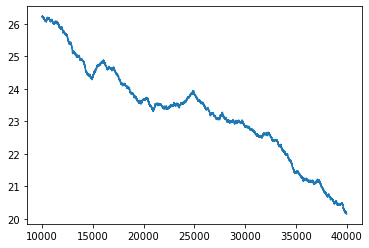

In [8]:
plot = plt.plot(pd.Series(metrics['loss'][:-10000]).rolling(10000).mean())

### The most important words for a tag

Linear models are interpretable. Calculate which words contribute the most to the probability of each of the tags.

In [9]:
model._vocab_inv = dict([(v, k) for (k, v) in model._vocab.items()])
top = 5
for tag in model._tags:
    top5_words = [model._vocab_inv[k] for (k, v) in 
                    sorted(model._w[tag].items(), key=lambda t: np.abs(t[1]), reverse=True)[:top]]
    print(tag, ':', ', '.join(top5_words)) 

ios : +, ios, mingw32, w64, x86_64
android : d, android, activity, twentythirteen, themes
javascript : javascript, x5c, 125, int, 7
c++ : c++, as, std, cout, cast
php : php, d, echo, x5c, 125
jquery : jquery, android, ajax, version, ready
html : android, int, gt, de, div
c# : dev, dcm, dist, std, java
python : d, python, def, td, py
java : dcm, dist, dev, println, java


For many tags, the presence of the tag itself in the sentence is an important signal, and for many, the tag itself is the strongest signal, which is not surprising.

### Predicting tags for new questions

Implement the method `predict_proba`, which takes a model and a string containing the question and returns a list of predicted question tags with their probabilities.

In [10]:
def predict_proba(model, sentence):
    p = {}
    for tag in model._tags:
        z = model._b[tag]
        for word in sentence.split(' '):
            if word not in model._vocab:
                continue
            z += model._w[tag][model._vocab[word]]
        sigma = 1 / (1 + np.exp(-z)) if z >= 0 else 1 - 1 / (1 + np.exp(z))
        p[tag] = sigma
    return p

In [11]:
new = pd.read_csv('../data/external/new_question.tsv', sep='\t', names=['question', 'tags'])
sentence = new['question'][0]
sentence

"I want to improve my coding skills, so I have planned write a Mobile Application.need to choose between Apple's iOS or Google's Android. my background: I have done basic programming in .Net,C/C++,Python and PHP in college, so got OOP concepts covered. about my skill level, I just know concepts and basic syntax. But can't write complex applications, if asked :( So decided to hone my skills, And I wanted to know which is easier to learn for a programming n00b. A) iOS which uses Objective C B) Android which uses Java. I want to decide based on difficulty level"

Preprocessing of the question (sentence) will only include converting it to lower case and deleting commas.

In [12]:
pred = predict_proba(model, sentence.lower().replace(',', ''))
tag_preds = sorted(pred.items(), key=lambda t: t[1], reverse=True)
list(filter(lambda t: t[1] > 0.7, tag_preds))

[('ios', 0.9963206300906883), ('android', 0.7949468821331378)]

In [13]:
new['tags'][0].split()

['java', 'android', 'objective-c', 'ios']